In [308]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


/kaggle/input/airlinefleet/Fleet Data.csv


In [309]:
ds = pd.read_csv('../input/airlinefleet/Fleet Data.csv')
ds.head()

,Parent Airline,Airline,Aircraft Type,Current,Future,Historic,Total,Orders,Unit Cost,Total Cost (Current),Average Age
0,Aegean Airlines,Aegean Airlines,Airbus A319,1.0,NaN,3.0,4.0,NaN,$90,$90,11.6
1,Aegean Airlines,Olympic Air,Airbus A319,NaN,NaN,8.0,8.0,NaN,$90,$0,NaN
2,Aegean Airlines,Aegean Airlines,Airbus A320,38.0,NaN,3.0,41.0,NaN,$98,"$3,724",7.5
3,Aegean Airlines,Olympic Air,Airbus A320,NaN,NaN,9.0,9.0,NaN,$98,$0,NaN
4,Aegean Airlines,Aegean Airlines,Airbus A321,8.0,NaN,NaN,8.0,NaN,$115,$919,10.3


Clean the Data. Remove dollar signs, commas. If the number of current, future, history, or orders is NaN, we'll assume that means 0. Also, parent airline and airline is redundant. There's nearly double the amount of Airlines compared to parent airlines, so we'll throw that away and only look at parent airlines.

In [310]:
print(ds.shape)
print(ds["Current"].isna().sum())

def clean(val):
    val = str(val)
    val = val.replace("$", "").replace(",", "")
    if val != "nan":
        val = int(val)
    return val

ds[["Current", "Future", "Historic", "Total", "Orders"]] = ds[[
    "Current", "Future", "Historic", "Total", "Orders"]].fillna(0)
ds["Unit Cost"] = ds["Unit Cost"].apply(clean)
ds["Total Cost (Current)"] = ds["Total Cost (Current)"].apply(clean)
ds.drop(columns = "Airline", inplace = True)
ds.rename(columns = {"Parent Airline" : "Airline", "Historic" : "Past", "Current" : "Present"}, inplace = True)

(1583, 11)
724


Before we get any further, it's important to note that the Future and Orders column appear to represent the same thing, and according to the description they do, the values are just from different sources. In order to account for this, we'll create a new column representing the average value of these two, and then add that to our new total. If we had access to which site was more reliable we could weigh the average accordingly, but unfortunately that info is not given. First we're going to have to alter our old total column since it only accounts for Future and not Orders.

In [311]:
ds["Total"] = ds["Total"] - ds["Future"]
ds["Future"] = ds["Future"] + ds["Orders"]
#use floor for a conservative estimate
ds["Future"] = ds["Future"].apply(lambda x: math.floor(x/2))
ds.drop(columns = "Orders", inplace = True)
ds["Total"] = ds["Total"] + ds["Future"]

Now we can look at the most popular airplanes, along with their assosciated cost and age.

In [312]:
plane_data = ds.groupby("Aircraft Type", as_index = False)[["Past", "Present", "Future", "Total"]].sum()
plane_data = plane_data.sort_values(by = ["Total"], ascending = False)
plane_data = plane_data.merge(ds[["Aircraft Type", "Unit Cost"]], on = ["Aircraft Type"], how = "left")
plane_data.drop_duplicates(subset = ["Aircraft Type"], inplace = True)
plane_data.head()

,Aircraft Type,Past,Present,Future,Total,Unit Cost
0,Boeing 737,3873.0,5328.0,1183,10383.0,74
147,Airbus A320,928.0,3299.0,1295,5502.0,98
282,Airbus A321,173.0,1231.0,562,1966.0,115
361,Boeing 747,1479.0,376.0,14,1866.0,316
425,Boeing 777,153.0,1305.0,232,1690.0,295


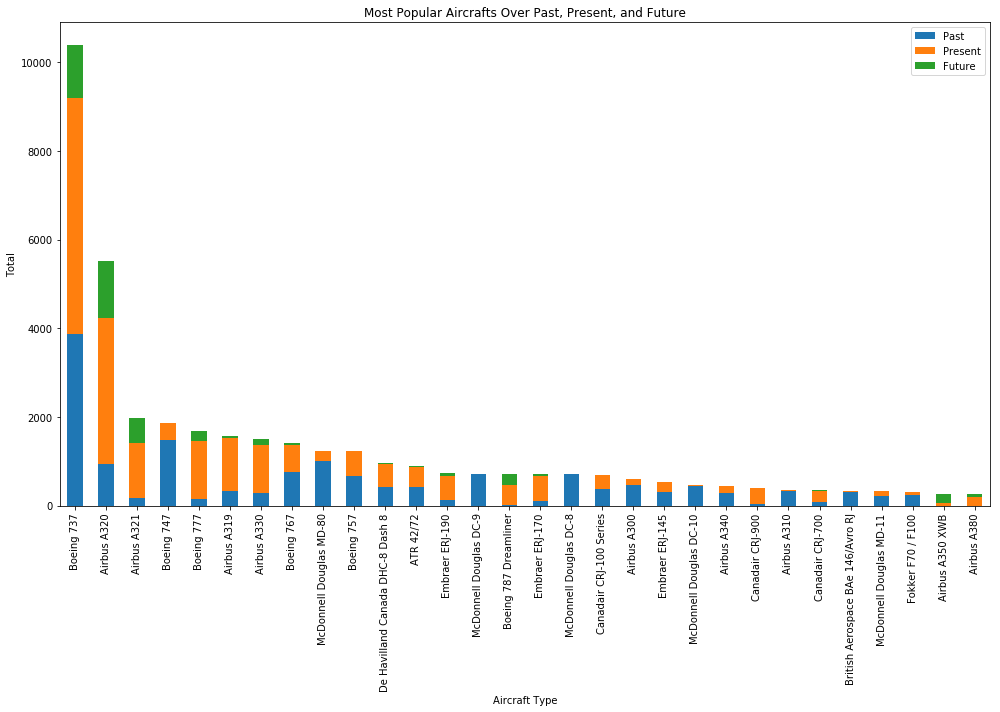

In [313]:
ax = plane_data[:30].plot(kind = "bar", x = "Aircraft Type", y = ["Past", "Present", "Future"], 
                          figsize = (14,10), stacked = True)
ax.set_ylabel("Total")
ax.set_title("Most Popular Aircrafts Over Past, Present, and Future")
plt.tight_layout()

We can compare the leaders of each individual category (past, present, future) to get a more concrete idea of things.

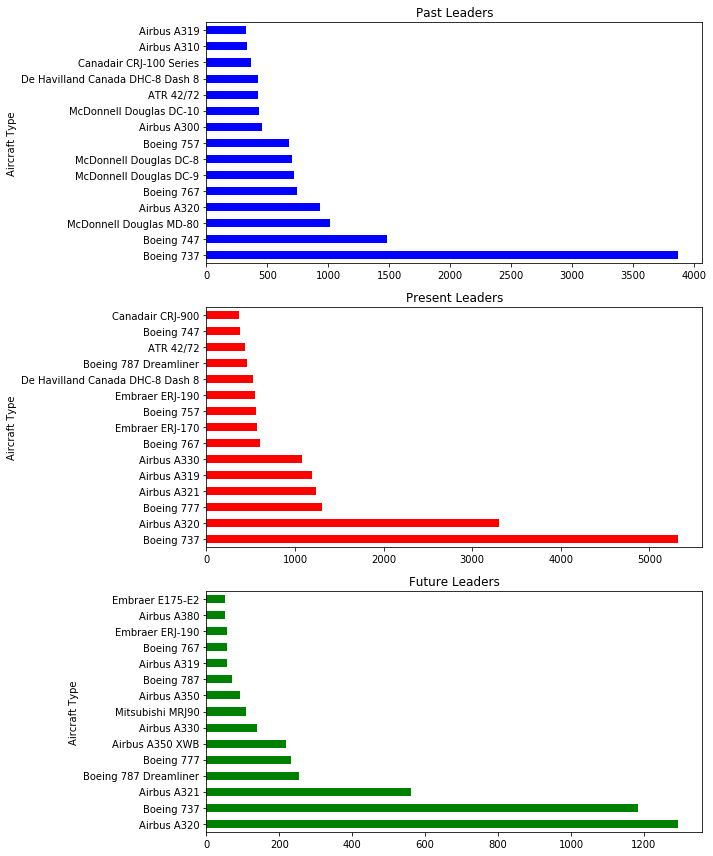

In [314]:
past_leaders = plane_data.sort_values(by = "Past", ascending = False)
present_leaders = plane_data.sort_values(by = "Present", ascending = False)
future_leaders = plane_data.sort_values(by = "Future", ascending = False)
fig, axes = plt.subplots(3, 1, figsize = (10,12))
ax1 = plt.subplot(311)
past_leaders[:15].plot(kind = "barh", x = "Aircraft Type", y = "Past", legend = False, ax = ax1, color = "b")
ax1.set_title("Past Leaders")
ax2 = plt.subplot(312)
present_leaders[:15].plot(kind = "barh", x = "Aircraft Type", y = "Present", legend = False, ax = ax2, color = "r")
ax2.set_title("Present Leaders")
ax3 = plt.subplot(313)
future_leaders[:15].plot(kind = "barh", x = "Aircraft Type", y = "Future", legend = False, ax = ax3, color = "g")
ax3.set_title("Future Leaders")
plt.tight_layout()

It looks like the Boeing 737 is consistently among the most popular aircraft types overtime, along with the Airbus A320 (to a lesser degree). Additionally, it looks like we're phasing out of the Boeing 747 and into the Boeing 777 and Boeing 787 Dreamliner. Multiple variations of the Airbus are popular throughout each time period, with companies phasing out of the Airbus A310 and into the Airbus 330, 350 XWB, and 319.

In order to visualize explictly what I'm referring to, we can use a scatter plot to encorporate a multivariate analysis of the data, comparing trends of past versus present as well as present versus future.

Text(0.5, 1.0, 'Present vs Future Aircraft Type Leaders Excluding Outliers')

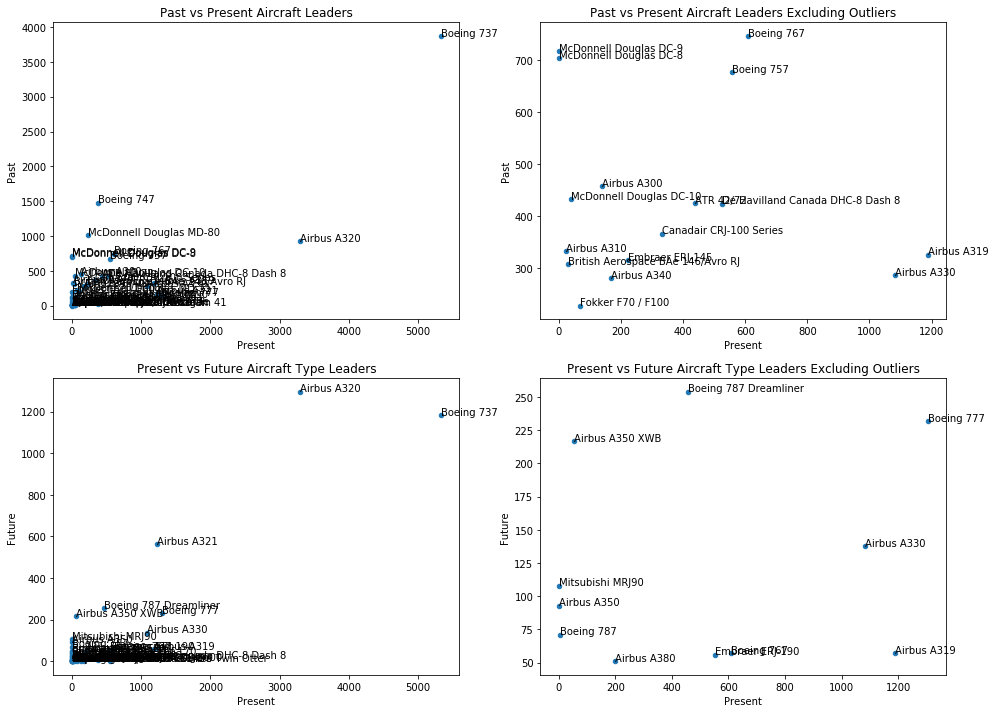

In [315]:
f, axes = plt.subplots(2,2, figsize = (16,12))
ax1 = plt.subplot(221)
past_leaders[:50].plot(kind = "scatter", x = "Present", y = "Past", ax = ax1)
past_leaders[["Present","Past",'Aircraft Type']][:50].apply(lambda x: ax1.text(*x),axis=1)
ax1.set_title("Past vs Present Aircraft Leaders")

ax2 = plt.subplot(222)
past_leaders[4:20].plot(kind = "scatter", x = "Present", y = "Past", ax = ax2)
past_leaders[["Present","Past",'Aircraft Type']][4:20].apply(lambda x: ax2.text(*x),axis=1)
ax2.set_title("Past vs Present Aircraft Leaders Excluding Outliers")

ax3 = plt.subplot(223)
future_leaders[:50].plot(kind = "scatter", x = "Present", y = "Future", ax = ax3)
future_leaders[["Present","Future",'Aircraft Type']][:50].apply(lambda x: ax3.text(*x),axis=1)
ax3.set_title("Present vs Future Aircraft Type Leaders")

ax4 = plt.subplot(224)
future_leaders[3:14].plot(kind = "scatter", x = "Present", y = "Future", ax = ax4)
future_leaders[["Present","Future",'Aircraft Type']][3:14].apply(lambda x: ax4.text(*x),axis=1)
ax4.set_title("Present vs Future Aircraft Type Leaders Excluding Outliers")

The two plots in our first column allow us to get a feel for the distribution of the data, while the two on the right side give a more in-depth visualization and we can see the aformentioned trends easier after accounting for outliers.

Now we'll look at the unit cost among these most popular aircrafts over each time period. It looks like the unit cost is remains fixed for each time period, so we don't have to consider the price of a specific aircraft going up or down overtime.


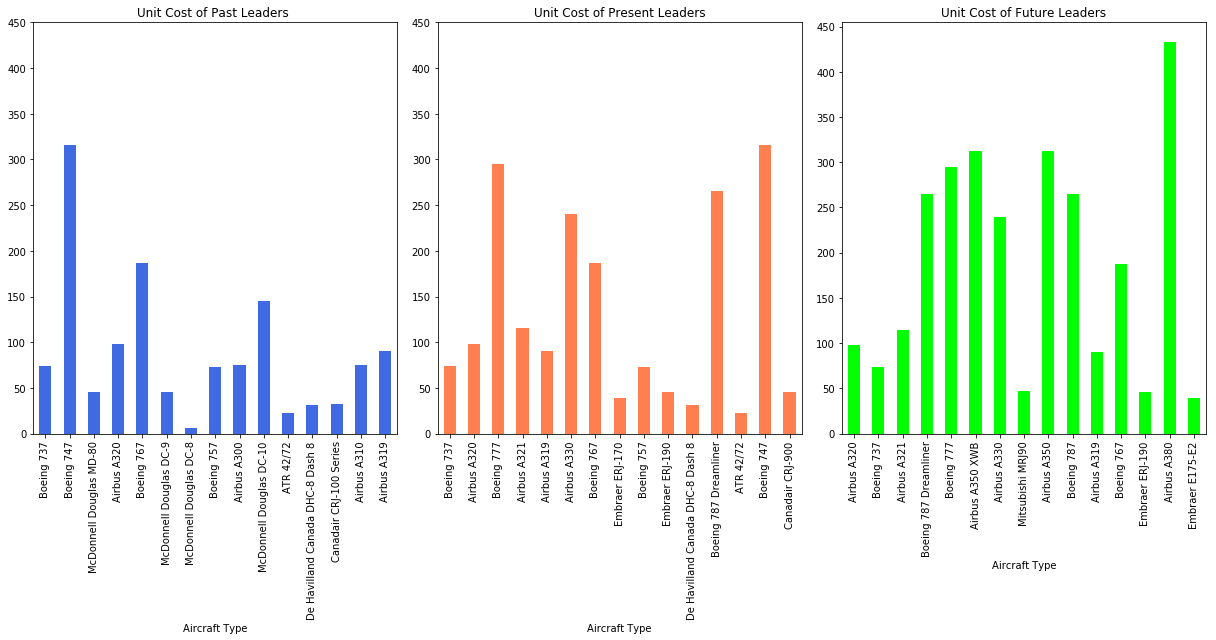

In [316]:
fig, axes = plt.subplots(1, 3, figsize = (17,9))
ax1 = plt.subplot(131)
past_leaders[:15].plot(kind = "bar", x = "Aircraft Type", y = "Unit Cost", legend = False, ax = ax1, color = "royalblue")
ax1.set_title("Unit Cost of Past Leaders ")
ax1.set_yticks(np.arange(0, 500, 50))
ax2 = plt.subplot(132)
present_leaders[:15].plot(kind = "bar", x = "Aircraft Type", y = "Unit Cost", legend = False, ax = ax2, color = "coral")
ax2.set_title("Unit Cost of Present Leaders")
ax2.set_yticks(np.arange(0, 500, 50))
ax3 = plt.subplot(133)
future_leaders[:15].plot(kind = "bar", x = "Aircraft Type", y = "Unit Cost", legend = False, ax = ax3, color = "lime")
ax3.set_title("Unit Cost of Future Leaders")
ax3.set_yticks(np.arange(0, 500, 50))
plt.tight_layout()

So it looks like the trend is that more expensive airplanes are becoming more popular over time. In the past, only three of the 15 most popular aircrafts have a unit price over 100, while present it creeps up to about half, and future 2/3 of the most popular aircrafts are over 100 per unit.

To get a better look at this trend, we can use a boxplot to look at the specific statistics of 

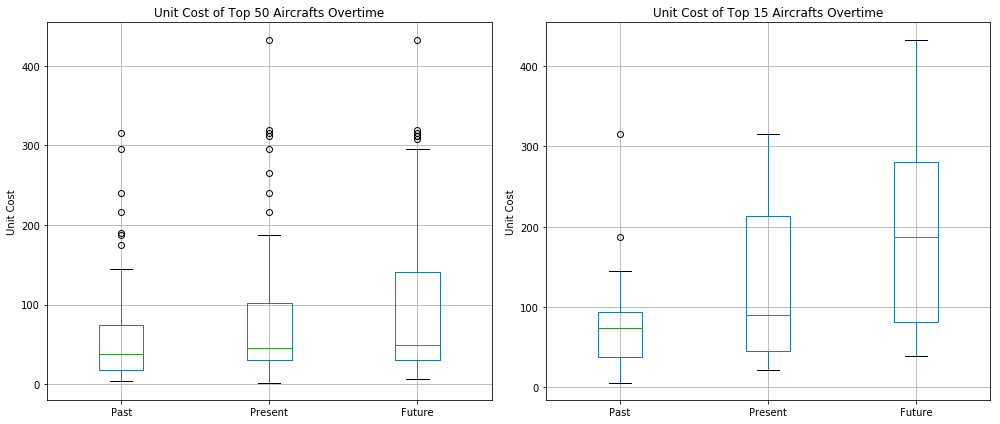

In [317]:
d = {"Past" : past_leaders["Unit Cost"][:50].values, "Present":present_leaders["Unit Cost"][:50].values,
     "Future":future_leaders["Unit Cost"][:50].values}
box_df = pd.DataFrame(data=d)
box_df['Past'] = box_df['Past'].astype(float)
box_df['Present'] = box_df['Present'].astype(float)
box_df['Future'] = box_df['Future'].astype(float)
f, ax = plt.subplots(1,2, figsize = (14,6))
ax1 = plt.subplot(121)
box_df.boxplot(ax = ax1)
ax1.set_title("Unit Cost of Top 50 Aircrafts Overtime")
ax1.set_ylabel("Unit Cost")

d2 = {"Past" : past_leaders["Unit Cost"][:15].values, "Present":present_leaders["Unit Cost"][:15].values,
     "Future":future_leaders["Unit Cost"][:15].values}
box_df2 = pd.DataFrame(data=d2)
box_df2['Past'] = box_df2['Past'].astype(float)
box_df2['Present'] = box_df2['Present'].astype(float)
box_df2['Future'] = box_df2['Future'].astype(float)
ax2 = plt.subplot(122)
box_df2.boxplot(ax = ax2)
ax2.set_title("Unit Cost of Top 15 Aircrafts Overtime")
ax2.set_ylabel("Unit Cost")
plt.tight_layout()

So we can see that even with the 50 most popular aircraft types in each time period the distribution is moving towards a higher unit cost for the planes. This is even more exaggerated when we take a look at the top 15 aircrafts for each time period.

Finally we'll analyze the relationship between unit cost and average age among the most popular aircrafts. We'll only look at average age with unit cost for present aircrafts since it doesn't really make sense to look at average age for past or future aircrafts.

In [318]:
plane_merged = plane_data.merge(ds[["Aircraft Type", "Average Age"]], on = ["Aircraft Type"], how = "left")
plane_merged.drop_duplicates(subset = ["Aircraft Type"], inplace = True)
plane_merged.dropna(subset = ["Average Age"], inplace = True)
plane_merged.sort_values(by = ["Present"], ascending = False)
plane_merged["Unit Cost"] = plane_merged["Unit Cost"].astype(float)
plane_merged["Average Age"] = plane_merged["Average Age"].astype(float)

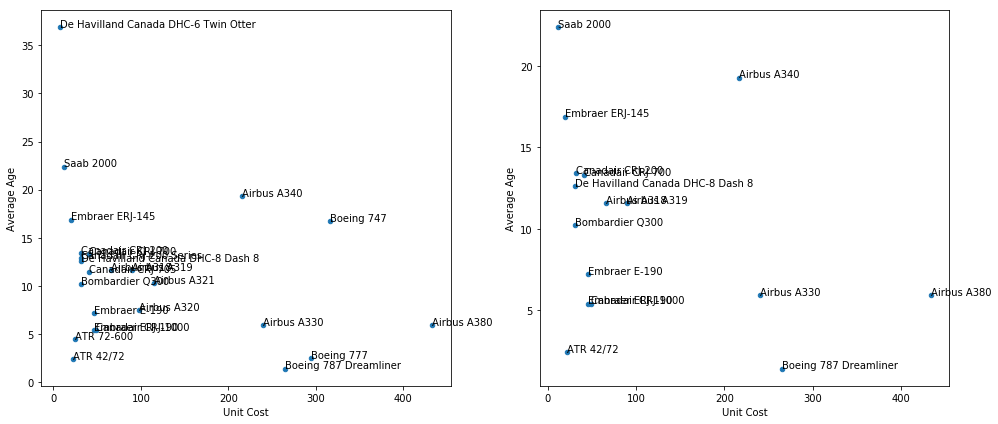

In [319]:
f, axes = plt.subplots(1,2,figsize = (14,6))
ax1 = plt.subplot(121)
plane_merged[:50].plot(kind = "scatter", x = "Unit Cost", y = "Average Age", ax = ax1)
plane_merged[["Unit Cost","Average Age",'Aircraft Type']][:50].apply(lambda x: ax1.text(*x),axis=1)

ax2 = plt.subplot(122)
plane_merged[4:20].plot(kind = "scatter", x = "Unit Cost", y = "Average Age", ax=ax2)
plane_merged[["Unit Cost","Average Age",'Aircraft Type']][4:20].apply(lambda x: ax2.text(*x),axis=1)
plt.tight_layout()

From this scatter plot it looks like there's no real trend in the data. The Boeing aircrafts definitely seem to be more expensive and newer, with the exception of the Boeing 747 which we saw was the second most popular aircraft in the past, so it would make sense that it lasts longer. Embraer appears to make low-budget planes whose age is slightly above that of the average. Airbus appears to make most of those mid-tier cost aircrafts that we saw earlier in the data, which are of varying ages.

Now we can incorporate companies into the mix. We'll go in a similar fashion, analyzing the most popular companies over all three time periods as well as each individually.

In [320]:
airline_data = ds.groupby(["Airline"], as_index = False)["Past", "Present", "Future", 
                                                         "Total"].sum().sort_values(by = "Total", ascending = False)
airline_data.head()

,Airline,Past,Present,Future,Total
25,American Airlines,1207.0,1410.0,173,2790.0
69,Lufthansa,988.0,737.0,141,1841.0
36,Delta Airlines,677.0,989.0,141,1807.0
54,IAG,899.0,608.0,94,1601.0
107,United Airlines,664.0,730.0,104,1536.0


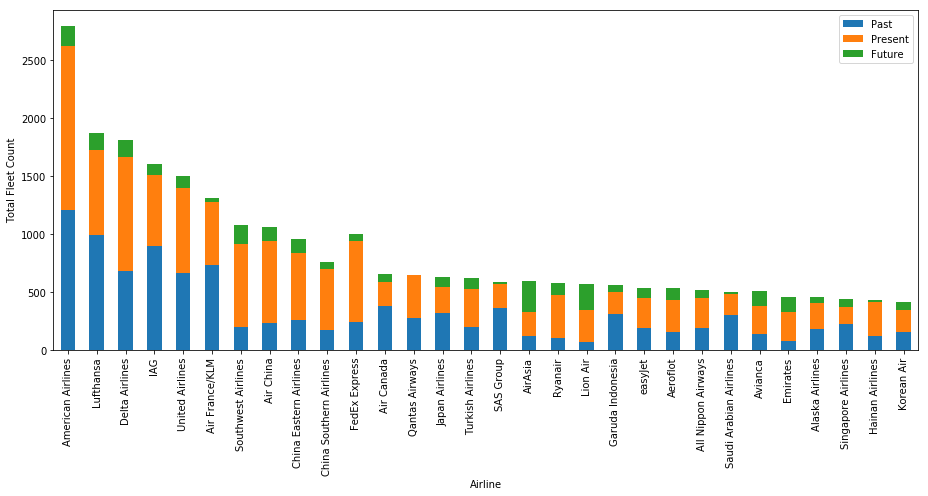

In [321]:
ax = airline_data[:30].plot(kind = "bar", stacked = True, x = "Airline", y = ["Past", "Present", "Future"], figsize = (13,7))
ax.set_ylabel("Total Fleet Count")
plt.tight_layout()

From this we can see that in aggregate, the top 10 airlines consist of American, European, and Chinese companies. Three of the top 5 are American companies. Outside of the top 10 locations of the airlines become much more sparse.

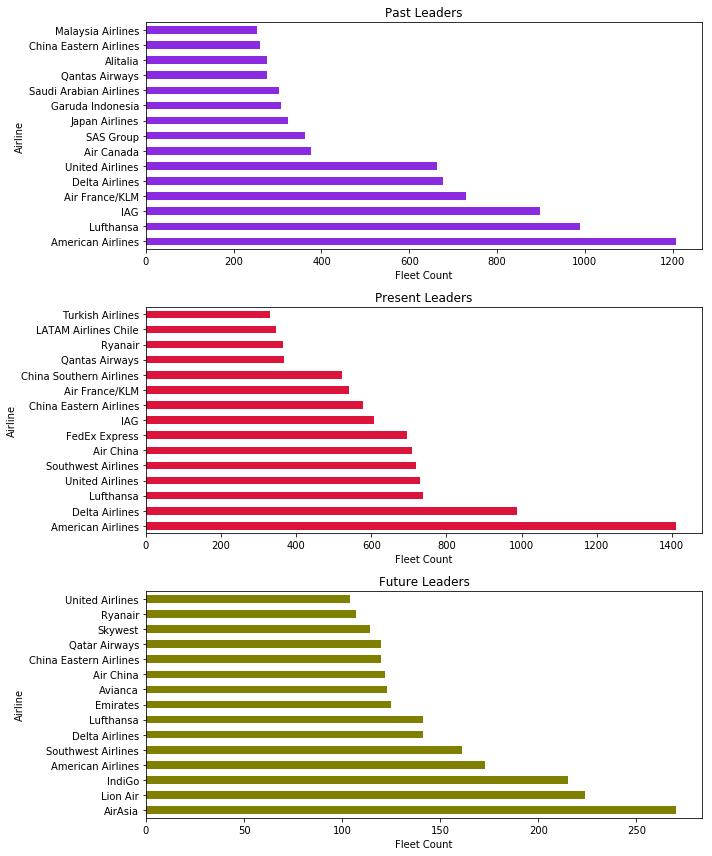

In [322]:
past_leaders = airline_data.sort_values(by = "Past", ascending = False)
present_leaders = airline_data.sort_values(by = "Present", ascending = False)
future_leaders = airline_data.sort_values(by = "Future", ascending = False)
fig, axes = plt.subplots(3, 1, figsize = (10,12))
ax1 = plt.subplot(311)
past_leaders[:15].plot(kind = "barh", x = "Airline", y = "Past", legend = False, ax = ax1, color = "blueviolet")
ax1.set_xlabel("Fleet Count")
ax1.set_title("Past Leaders")
ax2 = plt.subplot(312)
present_leaders[:15].plot(kind = "barh", x = "Airline", y = "Present", legend = False, ax = ax2, color = "crimson")
ax2.set_xlabel("Fleet Count")
ax2.set_title("Present Leaders")
ax3 = plt.subplot(313)
future_leaders[:15].plot(kind = "barh", x = "Airline", y = "Future", legend = False, ax = ax3, color = "olive")
ax3.set_xlabel("Fleet Count")
ax3.set_title("Future Leaders")
plt.tight_layout()

From this it is clear that American Airlines is consistently at or near the top in each time interval, while Southwest, Delta, and United lag behind slightly but remain among the leaders for present and future fleet counts. This coincides with the fact that four of the top 5 companies are US based during the present fleet interval. Interestingly enough, the future leaders have less European companies and more asian based companies. The top 3 future fleet leaders are all based out of Asia. This would make sense economocially and geopolitically as a lot of the countries in that region are going through their own industrial revolution right now.

Again in order to visualize the relationship between past vs present fleet size and present vs future for companies we can create a scatter plot. This will help us gain intuition on the direction of growth for the top airlines over the time periods. 


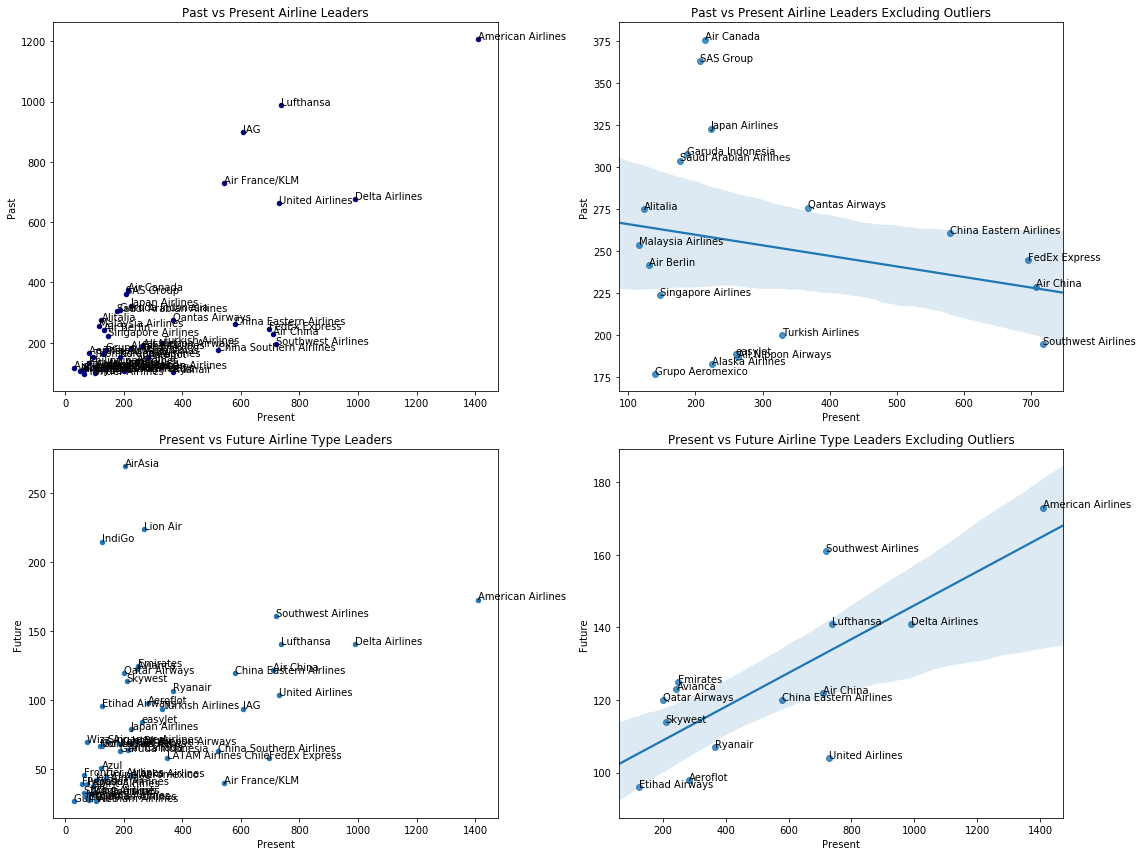

In [323]:
f, axes = plt.subplots(2,2, figsize = (16,12))
ax1 = plt.subplot(221)
past_leaders[:50].plot(kind = "scatter", x = "Present", y = "Past", ax = ax1, color = "DarkBlue")
past_leaders[["Present","Past",'Airline']][:50].apply(lambda x: ax1.text(*x),axis=1)
ax1.set_title("Past vs Present Airline Leaders")

ax2 = plt.subplot(222)
sns.regplot(x = past_leaders["Present"][6:25],y = past_leaders["Past"][6:25], ax = ax2)
past_leaders[["Present","Past",'Airline']][6:25].apply(lambda x: ax2.text(*x),axis=1)
ax2.set_title("Past vs Present Airline Leaders Excluding Outliers")

ax3 = plt.subplot(223)
future_leaders[:50].plot(kind = "scatter", x = "Present", y = "Future", ax = ax3)
future_leaders[["Present","Future",'Airline']][:50].apply(lambda x: ax3.text(*x),axis=1)
ax3.set_title("Present vs Future Airline Type Leaders")

ax4 = plt.subplot(224)
sns.regplot(x = future_leaders["Present"][3:17],y = future_leaders["Future"][3:17], ax = ax4)
future_leaders[["Present","Future",'Airline']][3:17].apply(lambda x: ax4.text(*x),axis=1)
ax4.set_title("Present vs Future Airline Type Leaders Excluding Outliers")
plt.tight_layout()

When looking at the first row, data points in the lower left quadrant correspond to a smaller past and present fleet size. The lower right quadrant corresponds to a larger current fleet size but smaller past size, which looks like mostly Chinese airlines and Southwest which is a relatively newer affordable airline, so this makes sense. Points in the upper right quadrant correspond to a large fleet size in both the past and present, which we already identified earlier which airlines these were. Interestingly enough, for upper right hand scatter plot representing a closer perspective of the top past airlines excluding the outliers, it looks like the data follows more of a negative correlation, meaning that a large past fleet size can be indicitive of a smaller current fleet size and vice versa.

For the lower second row, data points in the upper left quadrant correspond to a larger future fleet size and smaller current size. The of the quadrants follow from the previous paragraph, replacing past with future. This scatter plot follows a much more linear pattern, or looks like there's a positive correlation between currennt fleet size and future fleet size for the most part. 

Now we can delve deeper into the present time interval and take a closer look at the makeup of fleets for the current leaders. Because as aformentioned the leaders for the current interval in fleet count are mainly US, European, or Chinese based, we'll generalize into these three categories and look at the distributions respective of each region. The Regions will consist of the following:

US - American Airlines, Southwest Airlines, Delta Airlines, United Airlines

European - Lufthansa, IAG, Air France/KLM, Turkish Airlines

Chinese - Air China, China Eastern Airlines, China Southern Airlines 



In [324]:
us_cols = ["American Airlines", "Southwest Airlines", "Delta Airlines", "United Airlines"]
euro_cols = ["Lufthansa", "IAG", "Air France/KLM", "Turkish Airlines"]
chinese_cols = ["Air China", "China Eastern Airlines", "China Southern Airlines"]

us_data = ds.loc[ds["Airline"].isin(us_cols)]
euro_data = ds.loc[ds["Airline"].isin(euro_cols)]
chinese_data = ds.loc[ds["Airline"].isin(chinese_cols)]

us_data = us_data.groupby(["Aircraft Type"], as_index = False)["Past", 
                                                               "Present", "Future"].sum().sort_values(by = ["Present"], ascending = False)
euro_data = euro_data.groupby(["Aircraft Type"], as_index = False)["Past", 
                                                               "Present", "Future"].sum().sort_values(by = ["Present"], ascending = False)
chinese_data = chinese_data.groupby(["Aircraft Type"], as_index = False)["Past", 
                                                               "Present", "Future"].sum().sort_values(by = ["Present"], ascending = False)

In [325]:
boeing_ind = us_data["Aircraft Type"].str.contains("Boeing")
boeing = us_data[boeing_ind.values]
#boeing.head()
airbus_ind = us_data["Aircraft Type"].str.contains("Airbus")
airbus = us_data[airbus_ind.values]

canadair_ind = us_data["Aircraft Type"].str.contains("Canadair")
canadair = us_data[canadair_ind.values]

embraer_ind = us_data["Aircraft Type"].str.contains("Embraer")
embraer= us_data[embraer_ind.values]

mcdonnell_ind = us_data["Aircraft Type"].str.contains("McDonnell")
mcdonnell = us_data[mcdonnell_ind.values]
us_pie_df = pd.DataFrame({"Present": [boeing["Present"].sum(), 
                                     airbus["Present"].sum(), canadair["Present"].sum(), embraer["Present"].sum()],
                         "Future": [boeing["Future"].sum(), 
                                     airbus["Future"].sum(), canadair["Future"].sum(), embraer["Future"].sum()]}, 
                        index = ["Boeing", "Airbus", "Canadair", "Embraer"])

In [326]:
boeing_ind = euro_data["Aircraft Type"].str.contains("Boeing")
boeing = euro_data[boeing_ind.values]

airbus_ind = euro_data["Aircraft Type"].str.contains("Airbus")
airbus = euro_data[airbus_ind.values]

canadair_ind = euro_data["Aircraft Type"].str.contains("Canadair")
canadair = euro_data[canadair_ind.values]

embraer_ind = euro_data["Aircraft Type"].str.contains("Embraer")
embraer= euro_data[embraer_ind.values]

mcdonnell_ind = euro_data["Aircraft Type"].str.contains("McDonnell")
mcdonnell = euro_data[mcdonnell_ind.values]
euro_pie_df = pd.DataFrame({"Present": [boeing["Present"].sum(), 
                                     airbus["Present"].sum(), canadair["Present"].sum(), embraer["Present"].sum()],
                         "Future": [boeing["Future"].sum(), 
                                     airbus["Future"].sum(), canadair["Future"].sum(), embraer["Future"].sum()]}, 
                        index = ["Boeing", "Airbus", "Canadair", "Embraer"])

In [327]:
boeing_ind = chinese_data["Aircraft Type"].str.contains("Boeing")
boeing = chinese_data[boeing_ind.values]

airbus_ind = chinese_data["Aircraft Type"].str.contains("Airbus")
airbus = chinese_data[airbus_ind.values]

canadair_ind = chinese_data["Aircraft Type"].str.contains("Canadair")
canadair = chinese_data[canadair_ind.values]

embraer_ind = chinese_data["Aircraft Type"].str.contains("Embraer")
embraer= chinese_data[embraer_ind.values]

mcdonnell_ind = chinese_data["Aircraft Type"].str.contains("McDonnell")
mcdonnell = chinese_data[mcdonnell_ind.values]
chinese_pie_df = pd.DataFrame({"Present": [boeing["Present"].sum(), 
                                     airbus["Present"].sum(), canadair["Present"].sum(), embraer["Present"].sum()],
                         "Future": [boeing["Future"].sum(), 
                                     airbus["Future"].sum(), canadair["Future"].sum(), embraer["Future"].sum()]}, 
                        index = ["Boeing", "Airbus", "Canadair", "Embraer"])

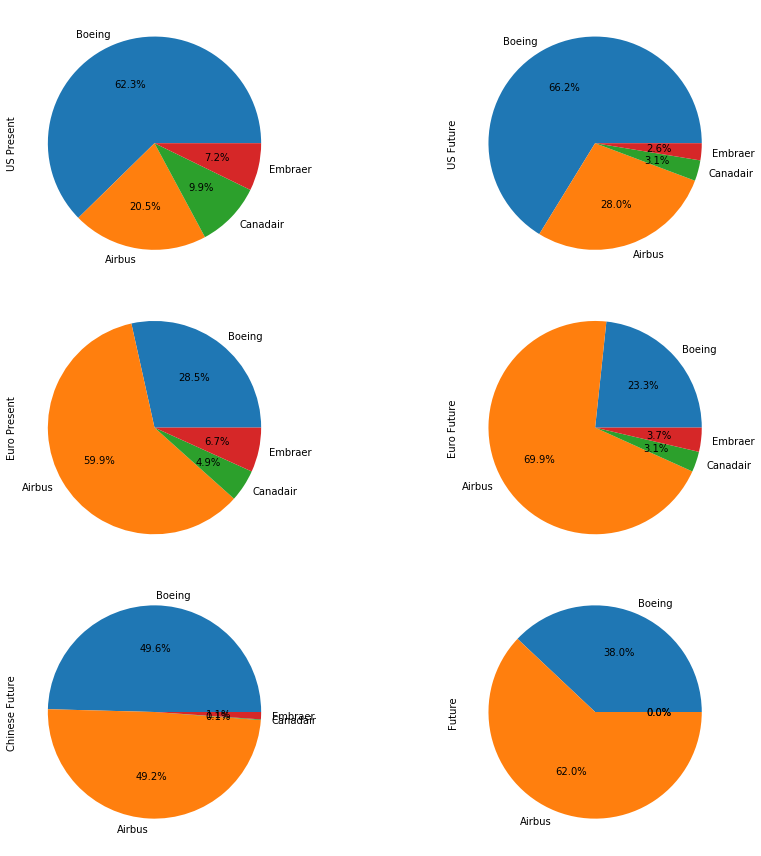

In [328]:
f, axes = plt.subplots(3, 2, figsize = (14,12))

ax1 = plt.subplot(321)
us_pie_df.plot(kind = "pie", y = "Present", legend = False, autopct="%1.1f%%", ax = ax1)
ax1.set_ylabel("US Present")

ax2 = plt.subplot(322)
us_pie_df.plot(kind = "pie", y = "Future", legend = False, autopct="%1.1f%%", ax = ax2)
ax2.set_ylabel("US Future")

ax3 = plt.subplot(323)
euro_pie_df.plot(kind = "pie", y = "Present", legend = False, autopct="%1.1f%%", ax = ax3)
ax3.set_ylabel("Euro Present")

ax4 = plt.subplot(324)
euro_pie_df.plot(kind = "pie", y = "Future", legend = False, autopct="%1.1f%%", ax = ax4)
ax4.set_ylabel("Euro Future")

ax5 = plt.subplot(325)
chinese_pie_df.plot(kind = "pie", y = "Present", legend = False, autopct="%1.1f%%", ax = ax5)
ax5.set_ylabel("Chinese Present")

ax6 = plt.subplot(326)
chinese_pie_df.plot(kind = "pie", y = "Future", legend = False, autopct="%1.1f%%", ax = ax6)
ax5.set_ylabel("Chinese Future")
plt.tight_layout()

Interestingly enough all three of these regions had the same four main aircraft manufactuers of Boeing, Airbus, Embraer, and Canadair.

The main US airlines are the only region that is majority Boeing and is sticking with Boeing in the future, although they are increasing their production of the Airbus Aircrafts by about 10% in relation to the whole fleet.

The European airlines have a sort of reverse relation to that of the US, in the sense that they're majority airbus and sticking with that, moving even farther away from Boeing in the future. 

The Chinese is the healthy medium, in which they're currently pretty evenly split between Airbus and Boeing, but moving towards favoring Airbus in the future.

In summary it's clear that Airbus and Boeing are the two main manufacturers, with an emphasis in more Airbus aircrafts in the future.